# Testing data analysis scripts of a run

In case you only have the h5 files and not the .json

In [1]:
%matplotlib notebook
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from escape.parse import swissfel
import h5py
from jungfrau_utils import apply_gain_pede, apply_geometry
h5py.enable_ipython_completer()
import time
import sys

In [2]:
sys.path.insert(0, '../src/')
from data_analysis import *
from integrators import *

In [26]:
n_shots = 1000
run = '0080_droplets_10um_20mm'
path = '/sf/bernina/data/p17743/res/scan_info/'
# load data                                                                         
file_path = '%srun%s.json'%(path,run)
print('-- Loading data:%s'%file_path)
data = swissfel.parseScanEco_v01(file_path,createEscArrays=True,memlimit_mD_MB=50)
jf7 = data['JF07T32V01'] # JungFrau data
jf3 = data['JF03T01V01'] # i0 monitor data
total_shots = jf7.data.shape[jf7.eventDim]
if (n_shots>total_shots) or (n_shots==0):
    n_shots = total_shots
print('-- JungFrau 16 Mpix detector contains %d shots - analyzing %d shots' % (total_shots, n_shots))

jf_pulse_id = jf7.eventIds[:n_shots] # event ID at 25 Hz
evcodes = data['SAR-CVME-TIFALL5:EvtSet'] # trigger codes in 256 channels at 100 Hz
laser_on = evcodes.data[:,20].compute() # laser trigger at 100 Hz
pulse_id = evcodes.eventIds # event ID at 100 Hz
laser_i0 = data['SARES20-LSCP9-FNS:CH1:VAL_GET'].data.compute() # laser i0 at 100 Hz

matched_id = np.isin(pulse_id, jf_pulse_id) # matched IDs at 25 Hz in 100 Hz arrays
assert (np.sum(matched_id) ==  len(jf_pulse_id))
print('-- Asserting that %d matched IDs sum up to %d JF7 event IDs' % (np.sum(matched_id), len(jf_pulse_id)))
laser_on = laser_on[matched_id].astype(np.bool) # laser trigger at 25 Hz
laser_i0 = laser_i0[matched_id] # laser i0 at 25 Hz

-- Loading data:/sf/bernina/data/p17743/res/scan_info/run0080_droplets_10um_20mm.json
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH4:2 in cycle 0
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH7:2 in cycle 0
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH5:2 in cycle 0
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH6:2 in cycle 0
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH6:2 in cycle 1
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH5:2 in cycle 1
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH7:2 in cycle 1
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH4:2 in cycle 1
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH6:2 in cycle 2
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH5:2 in cycle 2
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH7:2 in cycle 2
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH4:2 in cycle 2
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH6:2 in cycle 3
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH5:2 in cycle 3
Found empty dataset in SLAAR21-LSCP1-LAS6991:C

In [27]:
print('-- Loading corrections')
gains,pede,noise,mask = load_corrections(run)
gains_i0,pede_i0,noise_i0,mask_i0 = load_corrections_i0(run)

-- Loading corrections
using pedestals from: /sf/bernina/data/p17743/res/JF_pedestal/pedestal_20190201_0835.JF07T32V01.res.h5


In [28]:
t1 = time.time()
icorr = apply_gain_pede(jf7.data[0].compute(),G=gains, P=pede, pixel_mask=mask)
icorr_geom = apply_geometry(icorr,'JF07T32V01')
mask_geom = ~apply_geometry(~(mask>0),'JF07T32V01')
icorr_geom[mask_geom] = 0 #np.nan
avg_img_even = np.zeros_like(icorr_geom)
avg_img_odd = np.zeros_like(icorr_geom)
mask_inv = np.logical_not(mask_geom) #inversed: 0 masked, 1 not masked  
iq_threshold = 0.004
hits_even = 0
hits_odd = 0

# initialise for angular integration                                        
rad_dist = radial_distances(icorr_geom, center=(2117,2222))
ra = RadialAverager(rad_dist, mask_inv)
r  = ra.bin_centers
iq = ra(icorr_geom)
iqs = np.zeros((n_shots, iq.shape[0]))
i0 = np.zeros((n_shots, ))
iqs[0] = iq
i0[0] = get_i0(jf3.data[0].compute(), gains_i0, pede_i0, mask_i0)
print('s.%i, %.1f Hz: %.2f photon/pix' % (1, 1.0/(time.time() - t1), np.mean(icorr_geom[mask_inv]/9.5)))
roi_min = 5
roi_max = 80

for i in range(1,n_shots):
    t1 = time.time()
    icorr = apply_gain_pede(jf7.data[i].compute(),G=gains, P=pede, pixel_mask=mask)
    icorr_geom = apply_geometry(icorr,'JF07T32V01')
    i0[i] = get_i0(jf3.data[i].compute(), gains_i0, pede_i0, mask_i0)
    icorr_geom[mask_geom] = 0
    iq = ra(icorr_geom)
    iqs[i] = iq
    if (iq[roi_min:roi_max]/i0[i]/9.5).mean() > iq_threshold:
    #if iq[roi_min:roi_max].mean() > iq_threshold:
        if (i % 2) == 0:
            avg_img_even += icorr_geom
            hits_even += 1
            print('s.%i, %.1f Hz: %.2f photon/pix, %.3f photon/i0/pix: EVEN HIT' % (i+1, 1.0/(time.time() - t1), np.mean(icorr_geom[mask_inv]/9.5), (iq[roi_min:roi_max]/i0[i]/9.5).mean()))
        else:
            avg_img_odd += icorr_geom
            hits_odd += 1
            print('s.%i, %.1f Hz: %.2f photon/pix, %.3f photon/i0/pix: ODD HIT' % (i+1, 1.0/(time.time() - t1), np.mean(icorr_geom[mask_inv]/9.5), (iq[roi_min:roi_max]/i0[i]/9.5).mean()))
    else:
        print('s.%i, %.1f Hz: %.2f photon/pix, %.3f photon/i0/pix' % (i+1, 1.0/(time.time() - t1), np.mean(icorr_geom[mask_inv]/9.5), (iq[roi_min:roi_max]/i0[i]/9.5).mean()))
avg_img_even /= hits_even
avg_img_odd /= hits_odd
print('-- DONE! even: %d hits, odd: %d hits, total hitrate: %.1f%%' % (hits_even, hits_odd, 100*(hits_even+hits_odd)/n_shots))

s.1, 0.6 Hz: 0.09 photon/pix
s.2, 1.9 Hz: 0.10 photon/pix, 0.002 photon/i0/pix
s.3, 2.0 Hz: 0.13 photon/pix, 0.002 photon/i0/pix
s.4, 2.1 Hz: 0.12 photon/pix, 0.002 photon/i0/pix
s.5, 2.1 Hz: 1.48 photon/pix, 0.018 photon/i0/pix: EVEN HIT
s.6, 2.2 Hz: 0.11 photon/pix, 0.002 photon/i0/pix
s.7, 2.2 Hz: 0.10 photon/pix, 0.001 photon/i0/pix
s.8, 2.0 Hz: 0.11 photon/pix, 0.002 photon/i0/pix
s.9, 2.2 Hz: 0.11 photon/pix, 0.002 photon/i0/pix
s.10, 2.2 Hz: 0.10 photon/pix, 0.002 photon/i0/pix
s.11, 2.2 Hz: 0.10 photon/pix, 0.001 photon/i0/pix
s.12, 2.2 Hz: 0.10 photon/pix, 0.002 photon/i0/pix
s.13, 2.2 Hz: 0.11 photon/pix, 0.002 photon/i0/pix
s.14, 2.2 Hz: 0.10 photon/pix, 0.002 photon/i0/pix
s.15, 2.2 Hz: 0.11 photon/pix, 0.002 photon/i0/pix
s.16, 2.2 Hz: 0.12 photon/pix, 0.001 photon/i0/pix
s.17, 2.2 Hz: 0.08 photon/pix, 0.002 photon/i0/pix
s.18, 2.2 Hz: 0.09 photon/pix, 0.002 photon/i0/pix
s.19, 2.3 Hz: 0.11 photon/pix, 0.002 photon/i0/pix
s.20, 2.2 Hz: 0.12 photon/pix, 0.002 photon/i0/pix


s.160, 2.1 Hz: 0.12 photon/pix, 0.002 photon/i0/pix
s.161, 2.1 Hz: 0.11 photon/pix, 0.002 photon/i0/pix
s.162, 2.1 Hz: 0.10 photon/pix, 0.002 photon/i0/pix
s.163, 2.0 Hz: 0.11 photon/pix, 0.002 photon/i0/pix
s.164, 2.1 Hz: 0.10 photon/pix, 0.002 photon/i0/pix
s.165, 2.1 Hz: 0.11 photon/pix, 0.002 photon/i0/pix
s.166, 2.1 Hz: 0.12 photon/pix, 0.002 photon/i0/pix
s.167, 2.1 Hz: 0.12 photon/pix, 0.002 photon/i0/pix
s.168, 2.1 Hz: 0.11 photon/pix, 0.002 photon/i0/pix
s.169, 2.1 Hz: 0.11 photon/pix, 0.001 photon/i0/pix
s.170, 2.1 Hz: 0.11 photon/pix, 0.002 photon/i0/pix
s.171, 2.1 Hz: 0.11 photon/pix, 0.002 photon/i0/pix
s.172, 2.1 Hz: 0.12 photon/pix, 0.001 photon/i0/pix
s.173, 2.2 Hz: 0.12 photon/pix, 0.002 photon/i0/pix
s.174, 2.1 Hz: 0.11 photon/pix, 0.002 photon/i0/pix
s.175, 2.1 Hz: 0.11 photon/pix, 0.002 photon/i0/pix
s.176, 2.1 Hz: 0.09 photon/pix, 0.002 photon/i0/pix
s.177, 2.1 Hz: 0.08 photon/pix, 0.002 photon/i0/pix
s.178, 2.1 Hz: 0.08 photon/pix, 0.002 photon/i0/pix
s.179, 2.1 H

s.317, 2.1 Hz: 0.11 photon/pix, 0.002 photon/i0/pix
s.318, 2.1 Hz: 0.11 photon/pix, 0.002 photon/i0/pix
s.319, 2.1 Hz: 0.12 photon/pix, 0.002 photon/i0/pix
s.320, 2.1 Hz: 0.11 photon/pix, 0.002 photon/i0/pix
s.321, 2.1 Hz: 0.07 photon/pix, 0.002 photon/i0/pix
s.322, 2.1 Hz: 0.10 photon/pix, 0.002 photon/i0/pix
s.323, 2.1 Hz: 0.10 photon/pix, 0.002 photon/i0/pix
s.324, 2.1 Hz: 0.08 photon/pix, 0.002 photon/i0/pix
s.325, 2.1 Hz: 0.10 photon/pix, 0.002 photon/i0/pix
s.326, 2.1 Hz: 0.10 photon/pix, 0.002 photon/i0/pix
s.327, 2.0 Hz: 0.08 photon/pix, 0.002 photon/i0/pix
s.328, 2.2 Hz: 0.07 photon/pix, 0.002 photon/i0/pix
s.329, 2.2 Hz: 0.10 photon/pix, 0.002 photon/i0/pix
s.330, 2.1 Hz: 0.09 photon/pix, 0.001 photon/i0/pix
s.331, 2.1 Hz: 0.08 photon/pix, 0.002 photon/i0/pix
s.332, 2.1 Hz: 0.12 photon/pix, 0.002 photon/i0/pix
s.333, 2.1 Hz: 0.11 photon/pix, 0.001 photon/i0/pix
s.334, 2.1 Hz: 0.11 photon/pix, 0.002 photon/i0/pix
s.335, 2.1 Hz: 1.65 photon/pix, 0.020 photon/i0/pix: EVEN HIT
s.

s.475, 2.1 Hz: 0.10 photon/pix, 0.002 photon/i0/pix
s.476, 2.1 Hz: 0.11 photon/pix, 0.001 photon/i0/pix
s.477, 2.1 Hz: 0.10 photon/pix, 0.001 photon/i0/pix
s.478, 2.1 Hz: 0.11 photon/pix, 0.001 photon/i0/pix
s.479, 2.1 Hz: 0.11 photon/pix, 0.002 photon/i0/pix
s.480, 2.1 Hz: 0.11 photon/pix, 0.002 photon/i0/pix
s.481, 2.1 Hz: 0.11 photon/pix, 0.001 photon/i0/pix
s.482, 2.1 Hz: 0.09 photon/pix, 0.002 photon/i0/pix
s.483, 2.1 Hz: 0.10 photon/pix, 0.002 photon/i0/pix
s.484, 2.1 Hz: 0.09 photon/pix, 0.002 photon/i0/pix
s.485, 2.0 Hz: 1.36 photon/pix, 0.021 photon/i0/pix: EVEN HIT
s.486, 2.1 Hz: 0.11 photon/pix, 0.002 photon/i0/pix
s.487, 2.1 Hz: 0.09 photon/pix, 0.002 photon/i0/pix
s.488, 2.1 Hz: 0.11 photon/pix, 0.002 photon/i0/pix
s.489, 2.1 Hz: 0.10 photon/pix, 0.002 photon/i0/pix
s.490, 2.1 Hz: 0.12 photon/pix, 0.002 photon/i0/pix
s.491, 2.1 Hz: 0.11 photon/pix, 0.002 photon/i0/pix
s.492, 2.1 Hz: 0.10 photon/pix, 0.001 photon/i0/pix
s.493, 2.1 Hz: 0.11 photon/pix, 0.001 photon/i0/pix
s.

s.633, 2.1 Hz: 0.09 photon/pix, 0.002 photon/i0/pix
s.634, 2.1 Hz: 0.11 photon/pix, 0.002 photon/i0/pix
s.635, 2.1 Hz: 0.10 photon/pix, 0.001 photon/i0/pix
s.636, 2.0 Hz: 0.11 photon/pix, 0.002 photon/i0/pix
s.637, 2.1 Hz: 0.11 photon/pix, 0.001 photon/i0/pix
s.638, 2.0 Hz: 0.12 photon/pix, 0.002 photon/i0/pix
s.639, 2.1 Hz: 0.09 photon/pix, 0.001 photon/i0/pix
s.640, 2.1 Hz: 0.11 photon/pix, 0.001 photon/i0/pix
s.641, 2.1 Hz: 0.11 photon/pix, 0.002 photon/i0/pix
s.642, 2.1 Hz: 0.10 photon/pix, 0.001 photon/i0/pix
s.643, 2.1 Hz: 0.10 photon/pix, 0.002 photon/i0/pix
s.644, 2.1 Hz: 0.12 photon/pix, 0.001 photon/i0/pix
s.645, 2.1 Hz: 0.12 photon/pix, 0.002 photon/i0/pix
s.646, 2.0 Hz: 0.12 photon/pix, 0.002 photon/i0/pix
s.647, 2.1 Hz: 0.11 photon/pix, 0.002 photon/i0/pix
s.648, 2.1 Hz: 0.12 photon/pix, 0.002 photon/i0/pix
s.649, 2.1 Hz: 0.11 photon/pix, 0.002 photon/i0/pix
s.650, 2.1 Hz: 0.10 photon/pix, 0.001 photon/i0/pix
s.651, 1.6 Hz: 0.11 photon/pix, 0.002 photon/i0/pix
s.652, 2.0 H

s.790, 2.1 Hz: 0.11 photon/pix, 0.002 photon/i0/pix
s.791, 2.1 Hz: 0.11 photon/pix, 0.002 photon/i0/pix
s.792, 2.1 Hz: 0.11 photon/pix, 0.001 photon/i0/pix
s.793, 2.1 Hz: 0.10 photon/pix, 0.002 photon/i0/pix
s.794, 2.1 Hz: 0.12 photon/pix, 0.001 photon/i0/pix
s.795, 2.1 Hz: 0.12 photon/pix, 0.002 photon/i0/pix
s.796, 2.1 Hz: 0.14 photon/pix, 0.002 photon/i0/pix
s.797, 2.2 Hz: 0.10 photon/pix, 0.002 photon/i0/pix
s.798, 2.1 Hz: 0.11 photon/pix, 0.002 photon/i0/pix
s.799, 2.1 Hz: 0.11 photon/pix, 0.001 photon/i0/pix
s.800, 2.1 Hz: 0.11 photon/pix, 0.001 photon/i0/pix
s.801, 2.1 Hz: 0.10 photon/pix, 0.002 photon/i0/pix
s.802, 2.1 Hz: 0.10 photon/pix, 0.002 photon/i0/pix
s.803, 2.2 Hz: 0.10 photon/pix, 0.002 photon/i0/pix
s.804, 2.1 Hz: 0.12 photon/pix, 0.002 photon/i0/pix
s.805, 2.1 Hz: 0.35 photon/pix, 0.005 photon/i0/pix: EVEN HIT
s.806, 2.1 Hz: 0.11 photon/pix, 0.002 photon/i0/pix
s.807, 2.1 Hz: 0.10 photon/pix, 0.002 photon/i0/pix
s.808, 2.1 Hz: 0.11 photon/pix, 0.001 photon/i0/pix
s.

s.947, 2.1 Hz: 0.14 photon/pix, 0.002 photon/i0/pix
s.948, 2.1 Hz: 0.11 photon/pix, 0.002 photon/i0/pix
s.949, 2.0 Hz: 0.12 photon/pix, 0.002 photon/i0/pix
s.950, 2.1 Hz: 0.10 photon/pix, 0.002 photon/i0/pix
s.951, 2.1 Hz: 0.10 photon/pix, 0.002 photon/i0/pix
s.952, 2.1 Hz: 0.10 photon/pix, 0.001 photon/i0/pix
s.953, 2.2 Hz: 0.13 photon/pix, 0.002 photon/i0/pix
s.954, 2.1 Hz: 0.12 photon/pix, 0.002 photon/i0/pix
s.955, 2.1 Hz: 0.12 photon/pix, 0.002 photon/i0/pix
s.956, 2.1 Hz: 0.12 photon/pix, 0.002 photon/i0/pix
s.957, 2.1 Hz: 0.99 photon/pix, 0.012 photon/i0/pix: EVEN HIT
s.958, 2.2 Hz: 0.11 photon/pix, 0.001 photon/i0/pix
s.959, 2.1 Hz: 0.12 photon/pix, 0.002 photon/i0/pix
s.960, 2.1 Hz: 0.12 photon/pix, 0.002 photon/i0/pix
s.961, 2.1 Hz: 0.11 photon/pix, 0.001 photon/i0/pix
s.962, 2.1 Hz: 0.11 photon/pix, 0.001 photon/i0/pix
s.963, 2.1 Hz: 0.10 photon/pix, 0.002 photon/i0/pix
s.964, 2.1 Hz: 0.11 photon/pix, 0.002 photon/i0/pix
s.965, 2.2 Hz: 0.11 photon/pix, 0.002 photon/i0/pix
s.

<IPython.core.display.Javascript object>


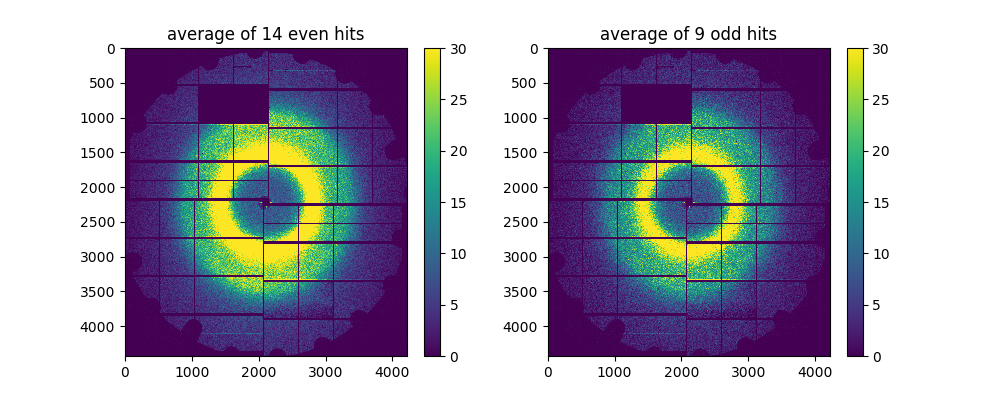

In [32]:
plt.figure(figsize=[10,4])
plt.subplot(1,2,1)
plt.title('average of %d even hits' % hits_even)
#plt.imshow(np.log(avg_img_even),aspect='auto',clim=[0,5])
plt.imshow(avg_img_even,aspect='auto',clim=[0,30])
plt.colorbar()

plt.subplot(1,2,2)
plt.title('average of %d odd hits' % hits_odd)
plt.imshow(avg_img_odd,aspect='auto',clim=[0,30])
plt.colorbar()

plt.savefig('run%s_2d_hits_even_vs_odd.png' % run)
plt.show()

In [33]:
iq_metric = iqs[:,5:80].mean(axis=1)/i0/9.5
bi,bf,db = iq_metric.min(),iq_metric.max(),.001
bins = np.arange(bi-db,bf+db,db)
hy,hx = np.histogram(iq_metric,bins=bins)
bin_centers = np.array([(bins[j]+bins[j+1])/2. for j in range(len(bins)-1)])

<IPython.core.display.Javascript object>


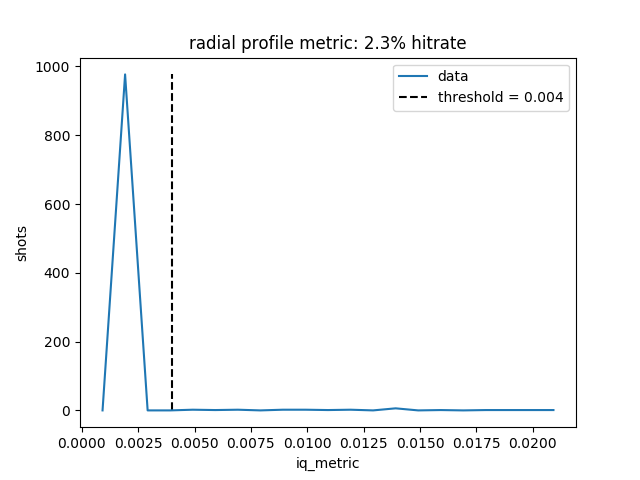

In [36]:
iq_threshold = 0.004
hits = iq_metric > iq_threshold
plt.figure()
plt.title('radial profile metric: %.1f%% hitrate' % (100*hits.sum()/n_shots))
plt.plot(bin_centers, hy, label='data')
plt.ylabel('shots')
plt.xlabel('iq_metric')
plt.vlines(iq_threshold,0,hy.max(),color='k',linestyles='dashed',label='threshold = %.3f' % iq_threshold)
plt.legend()
plt.savefig('run%s_radial_profile_hist.png' % run)
plt.show()

In [37]:
q = q_scale(r, detector_distance=0.12) # detector_distance=0.127 m according to Alex measurement
iqs_even = iqs[::2]
iqs_odd = iqs[1::2]
iq_avg_even = iqs_even[iq_metric[::2] > iq_threshold].mean(axis=0)
iq_avg_odd = iqs_odd[iq_metric[1::2] > iq_threshold].mean(axis=0)

<IPython.core.display.Javascript object>


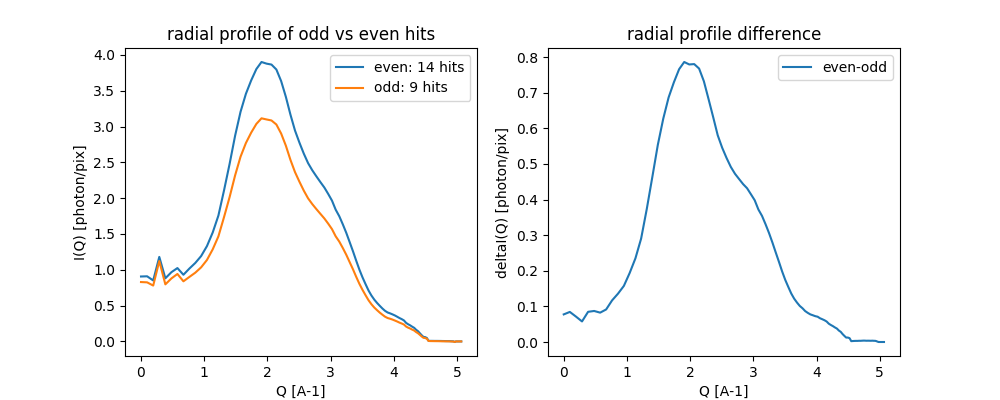

In [38]:
plt.figure(figsize=[10,4])
plt.subplot(1,2,1)
plt.title('radial profile of odd vs even hits')
plt.plot(q, iq_avg_even/9.5, label='even: %d hits' % hits_even)
plt.plot(q, iq_avg_odd/9.5, label='odd: %d hits' % hits_odd)
plt.ylabel('I(Q) [photon/pix]')
plt.xlabel('Q [A-1]')
plt.legend()

plt.subplot(1,2,2)
plt.title('radial profile difference')
plt.plot(q, (iq_avg_even-iq_avg_odd)/9.5, label='even-odd')
plt.ylabel('deltaI(Q) [photon/pix]')
plt.xlabel('Q [A-1]')
plt.legend()

plt.savefig('run%s_radial_profile_even_vs_odd.png' % run)
plt.show()

<IPython.core.display.Javascript object>


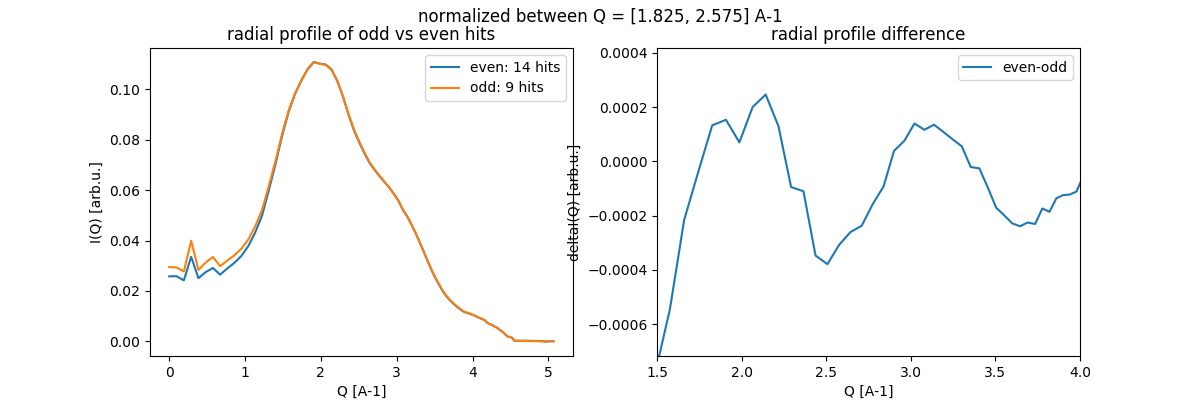

In [39]:
plt.figure(figsize=[12,4])
plt.suptitle('normalized between Q = [%.03f, %.03f] A-1' % (q[20], q[30]))
plt.subplot(1,2,1)
plt.title('radial profile of odd vs even hits')
plt.plot(q, iq_avg_even/iq_avg_even[20:30].sum(), label='even: %d hits' % hits_even)
plt.plot(q, iq_avg_odd/iq_avg_odd[20:30].sum(), label='odd: %d hits' % hits_odd)
plt.ylabel('I(Q) [arb.u.]')
plt.xlabel('Q [A-1]')
plt.legend()

plt.subplot(1,2,2)
plt.title('radial profile difference')
iq_diff_norm = (iq_avg_even/iq_avg_even[20:30].sum()-iq_avg_odd/iq_avg_odd[20:30].sum())
plt.plot(q, iq_diff_norm, label='even-odd')
plt.ylabel('deltaI(Q) [arb.u.]')
plt.xlabel('Q [A-1]')
plt.xlim([1.5,4.0])
plt.ylim([iq_diff_norm[17:60].min() - iq_diff_norm[17:60].std(), iq_diff_norm[17:60].max() + iq_diff_norm[17:60].std()])
plt.legend()
#plt.tight_layout()

plt.savefig('run%s_radial_profile_even_vs_odd_normalized+zoom.png' % run)
plt.show()

In [40]:
def normalize(array, lower_index, upper_index):
    n = np.sum(array[lower_index:upper_index])
    norm_array = array / n
    return norm_array

l = 20
h = 30

hit_avg  = np.average(iqs[hits,:], axis=0)/9.5 # to convert to photon/pix
miss_avg = np.average(iqs[np.logical_not(hits),:], axis=0)/9.5 # to convert to photon/pix

off_miss = np.average(iqs[np.logical_not(hits) * np.logical_not(laser_on),:], axis=0)
on_miss  = np.average(iqs[np.logical_not(hits) * laser_on,:], axis=0)
off_hit  = np.average(iqs[hits * np.logical_not(laser_on),:], axis=0)
on_hit   = np.average(iqs[hits * laser_on,:], axis=0)

signal = (normalize(on_hit, l, h) - normalize(off_hit, l, h)) # / normalize(off_hit, l, h)

# get a number of off hits equal to the number of on hits for SNR estimation
off_hits = iqs[hits * np.logical_not(laser_on),:]
off_hits_1 = np.average(off_hits[:-1:2], axis=0)
off_hits_2 = np.average(off_hits[1::2], axis=0)
off_diff = normalize(off_hits_1, l, h) - normalize(off_hits_2, l, h)

<IPython.core.display.Javascript object>


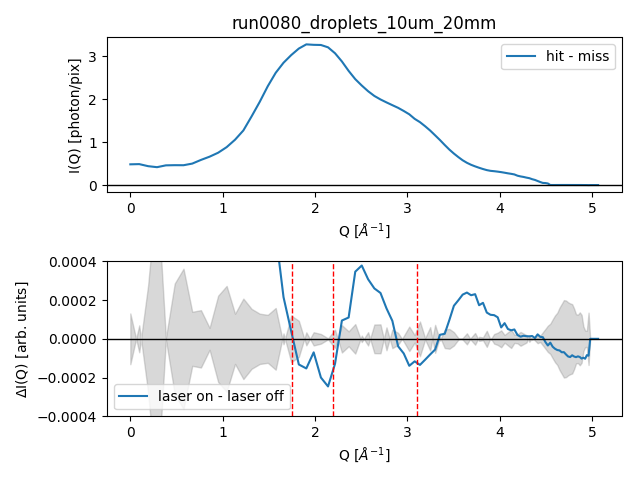

In [42]:
plt.figure()

plt.subplot(2,1,1)
plt.title('run%s'%run)
plt.plot(q, hit_avg - miss_avg)
plt.xlabel('Q [$\AA^{-1}$]')
plt.ylabel('I(Q) [photon/pix]')
plt.legend(['hit - miss'])
plt.axhline(0,c='black',lw=1)

ax = plt.subplot(2,1,2)
ax.plot(q, signal)
ax.fill_between(q, -off_diff, off_diff, color='grey', alpha=0.3)
plt.xlabel('q')
plt.ylabel('$\Delta$I(Q) [arb. units]')
plt.ylim([-4e-4,4e-4])
plt.xlabel('Q [$\AA^{-1}$]')
plt.axhline(0,c='black',lw=1)
plt.axvline(1.75,c='red',lw=1,ls='--')
plt.axvline(2.2,c='red',lw=1,ls='--')
plt.axvline(3.1,c='red',lw=1,ls='--')
plt.legend(['laser on - laser off'])
plt.tight_layout()


plt.savefig('run%s_radial_profile_on_vs_off_normalized.png' % run)
plt.show()